# 따릉이는 언제 타면 괜찮을까?

## 부제 :  서울시 공영자전거 따릉이 데이터가 날씨와 시간이 얼마나 영향을 미치는가 

## Dataset

- 서울시 공영자전거 따릉이의 2020년 대여이력 데이터 세트 (서울 열린데이터 광장)
- 서울시 공영자전거 따릉이의 2020년 대여소 정보 데이터 세트 (서울시 열린데이터 광장)
- 서울시 2020년 자치구별 날씨 데이터 (기상자료정보포털) 

## Process

1. 따릉이 **데이터 로드 및 전처리** 과정
2. 날씨 데이터와 병합(Merge)
3. **머신러닝 회귀** 모델링 (XGBoost를 이용한 이용건수에 관해 중요한 Feature 예측)

## Result

- 다른 예측모델과 0.5 정도 밖에 차이가 나지 않음
- 금천구 : 훈련 데이터 세트(4684, 13), 테스트 데이터 세트(1172, 13)
- 평균 MAE가 전체 MAE와 비슷할정도로 무난한 분포임.
- 대여 시간 피처가 가장 중요도가 높으며 대부분 오후 3시 이후부터  6시 이전까지 사용수가 증가함.
- 피쳐 중요도로는 대여시간, 주말, 강수량이 가장 높음.


## Team Introduce
- 팀장 : 강동우 (IT콘텐츠학과 16)
- 팀원 : 이하경 (컴퓨터공학과 20)


#  Data Processing
## 모듈 임포트

In [4]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings('ignore')

mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'AppleGothic'

## 따릉이 데이터 로드
### 따릉이 데이터 불러오기

In [9]:
import os
import glob

input_file = r'/Users/dongwoo/seoul_bike-Sharing_demand/data' # csv파일들이 있는 디렉토리 위치
output_file = r'/Users/dongwoo/seoul_bike-Sharing_demand/data/공공자전거 이용정보(시간대별)_20.csv' # 병합하고 저장하려는 파일명

allFile_list = sorted(glob.glob(os.path.join(input_file, '공공자전거 이용정보(시간대별)_*'))) # glob함수로 sales_로 시작하는 파일들을 모은다
print(allFile_list) # sorted()를 통해서 파일명 순으로 정렬한다.

allData = [] # 읽어 들인 csv파일 내용을 저장할 빈 리스트를 하나 만든다

for file in allFile_list:
    df = pd.read_csv(file,encoding='cp949') # for구문으로 csv파일들을 읽어 들인다
    allData.append(df) # 빈 리스트에 읽어 들인 내용을 추가한다

['/Users/dongwoo/seoul_bike-Sharing_demand/data/공공자전거 이용정보(시간대별)_19.12_20.056.csv', '/Users/dongwoo/seoul_bike-Sharing_demand/data/공공자전거 이용정보(시간대별)_20.06.csv', '/Users/dongwoo/seoul_bike-Sharing_demand/data/공공자전거 이용정보(시간대별)_20.07.csv', '/Users/dongwoo/seoul_bike-Sharing_demand/data/공공자전거 이용정보(시간대별)_20.08.csv', '/Users/dongwoo/seoul_bike-Sharing_demand/data/공공자전거 이용정보(시간대별)_20.09.csv', '/Users/dongwoo/seoul_bike-Sharing_demand/data/공공자전거 이용정보(시간대별)_20.10.csv', '/Users/dongwoo/seoul_bike-Sharing_demand/data/공공자전거 이용정보(시간대별)_20.11.csv', '/Users/dongwoo/seoul_bike-Sharing_demand/data/공공자전거 이용정보(시간대별)_20.12.csv']


### 데이터 파일 병합하기

In [10]:
dataCombine = pd.concat(allData, axis=0, ignore_index=True) # concat함수를 이용해서 리스트의 내용을 병합
# axis=0은 수직으로 병합함. axis=1은 수평. ignore_index=True는 인데스 값이 기존 순서를 무시하고 순서대로 정렬되도록 한다.

dataCombine.to_csv(output_file, index=False) # to_csv함수로 저장한다. 인데스를 빼려면 False로 설정

### 2019년 일자 제거하기

In [86]:
df = pd.read_csv("/Users/dongwoo/seoul_bike-Sharing_demand/data/공공자전거 이용정보(시간대별)_20.csv")
df['대여일자'] = df['대여일자'].astype('datetime64[ns]')
df.set_index('대여일자', inplace=True) # 대여 일자를 인덱스를 설정하기
df = df.loc['2020-01-01':'2020-12-31'] 
df = df.reset_index() #인덱스 정수형으로 초기화
df.head(5)

,대여일자,Unnamed: 0,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
0,2020-01-01,0,0,1044,1044. 굽은다리역,정기권,NaN,~10대,1,33.96,0.30,1280.0,6
1,2020-01-01,1,0,1656,1656. 중앙하이츠 아파트 입구,정기권,NaN,~10대,1,40.15,0.39,1690.0,6
2,2020-01-01,2,0,1337,1337. 돈암성당 옆,정기권,NaN,~10대,1,80.88,0.50,2150.0,12
3,2020-01-01,3,0,1984,1984. 구로구청,정기권,NaN,~10대,1,47.36,0.43,1840.0,25
4,2020-01-01,4,0,2601,2601. 석촌호수 서호사거리,정기권,NaN,~10대,1,29.34,0.26,1140.0,5


### 데이터 자료형 변경하기
-  대여소와 연령대, 성별이 `object`로 되어 있기 때문에 `category`로 변경한다.
-  운동량과 탄소량이 `object`로 되어 있기 때문에 `float64`로 변경한다.

In [16]:

df['운동량'].replace('\\N',np.nan, inplace=True)
df.dropna(subset=['운동량'], axis=0, inplace=True)
df['운동량'] = df['운동량'].astype('float64')

df['탄소량'].replace('\\N',np.nan, inplace=True)
df.dropna(subset=['탄소량'], axis=0, inplace=True)
df['탄소량'] = df['탄소량'].astype('float64')

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331907 entries, 95 to 18906569
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   대여일자    331907 non-null  object 
 1   대여시간    331907 non-null  int64  
 2   대여소번호   331907 non-null  int64  
 3   대여소명    331907 non-null  object 
 4   대여구분코드  331907 non-null  object 
 5   성별      156913 non-null  object 
 6   연령대코드   331907 non-null  object 
 7   이용건수    331907 non-null  int64  
 8   운동량     331907 non-null  float64
 9   탄소량     331907 non-null  float64
 10  이동거리    331907 non-null  float64
 11  사용시간    331907 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 148.4 MB


In [17]:
df['대여일자'] = df['대여일자'].astype('datetime64[ns]')
df['대여소명'] = df['대여소명'].astype('category')
df['대여구분코드'] = df['대여구분코드'].astype('category')
df['성별'] = df['성별'].astype('category')
df['연령대코드'] = df['연령대코드'].astype('category')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331907 entries, 95 to 18906569
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   대여일자    331907 non-null  datetime64[ns]
 1   대여시간    331907 non-null  int64         
 2   대여소번호   331907 non-null  int64         
 3   대여소명    331907 non-null  category      
 4   대여구분코드  331907 non-null  category      
 5   성별      156913 non-null  category      
 6   연령대코드   331907 non-null  category      
 7   이용건수    331907 non-null  int64         
 8   운동량     331907 non-null  float64       
 9   탄소량     331907 non-null  float64       
 10  이동거리    331907 non-null  float64       
 11  사용시간    331907 non-null  int64         
dtypes: category(4), datetime64[ns](1), float64(3), int64(4)
memory usage: 24.1 MB


### 저장하기

In [25]:
df.to_csv("/Users/dongwoo/seoul_bike-Sharing_demand/data/공공자전거 이용정보(시간대별)_20.csv")

## 금천구만 불러오기 #Potal

In [55]:
rental = pd.read_csv("/Users/dongwoo/seoul_bike-Sharing_demand/data/공공자전거 대여소 정보(21.01.31 기준).csv")
rental.tail()

,대여소\n번호,보관소(대여소)명,소재지(위치),상세주소,위도,경도,설치\n시기,LCD,QR,운영\n방식
2149,1085,래미안 솔베뉴(고덕로),강동구,양재대로1650,37.554569,127.145874,2020-01-13,NaN,20.0,QR
2150,1086,래미안 솔베뉴(구천면로),강동구,양재대로1650,37.550598,127.145454,2020-01-10,NaN,10.0,QR
2151,1088,풍납사거리(강동),강동구,성내동451-3,37.528122,127.119522,2020-01-14,NaN,12.0,QR
2152,1089,고덕 래미안힐스테이트(201동),강동구,고덕동 675,37.560600,127.146698,2020-01-13,NaN,10.0,QR
2153,1090,상일동역 2번출구 앞,강동구,고덕로 333,37.556789,127.166145,2020-01-13,NaN,10.0,QR


### 금천구에 해당하는 대여소 번호만 추출한다.

In [56]:
rental_no = rental.groupby('소재지(위치)')['대여소\n번호'].unique().loc['금천구']
rental_no

array([1804, 1805, 1806, 1808, 1809, 1812, 1814, 1816, 1819, 1820, 1821,
       1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1833,
       1834, 1835, 1836, 1839, 1840, 1841, 1842, 1843, 1845, 1846, 1847,
       1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858,
       1859, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870])

### 따릉이 데이터에서 해당하는 대여소 번호만 추출한다.

In [57]:
df = pd.read_csv("/Users/dongwoo/seoul_bike-Sharing_demand/data/공공자전거 이용정보(시간대별)_20.csv")
df = df[df['대여소번호'].isin(rental_no)]
df.shape

(331907, 13)

In [58]:
# df = df.reset_index()
# df['number'] = df['index']
df = df.drop('Unnamed: 0', axis=1)
df.head()

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
95,2020-01-01,0,1821,1821. 홈플러스 시흥점 맞은편 다비치안경 앞,정기권,NaN,20대,1,57.11,0.48,2090.0,19
96,2020-01-01,0,1824,1824. 독산근린공원 입구,정기권,NaN,20대,1,0.00,0.00,0.0,6
97,2020-01-01,0,1829,1829. 홈플러스 금천점 앞,정기권,NaN,20대,1,56.73,0.44,1910.0,14
100,2020-01-01,0,1827,1827. 독산보도육교 앞 자전거 보관소,정기권,NaN,20대,1,383.50,3.62,15620.0,82
159,2020-01-01,0,1824,1824. 독산근린공원 입구,정기권,NaN,30대,1,223.11,2.18,9390.0,34


In [60]:
df['운동량'].replace('\\N',np.nan, inplace=True)
df.dropna(subset=['운동량'], axis=0, inplace=True)
df['운동량'] = df['운동량'].astype('float64')

df['탄소량'].replace('\\N',np.nan, inplace=True)
df.dropna(subset=['탄소량'], axis=0, inplace=True)
df['탄소량'] = df['탄소량'].astype('float64')

df['대여일자'] = df['대여일자'].astype('datetime64[ns]')
df['대여소명'] = df['대여소명'].astype('category')
df['대여구분코드'] = df['대여구분코드'].astype('category')
df['성별'] = df['성별'].astype('category')
df['연령대코드'] = df['연령대코드'].astype('category')
df.info(memory_usage='deep')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331907 entries, 95 to 18906569
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   대여일자    331907 non-null  datetime64[ns]
 1   대여시간    331907 non-null  int64         
 2   대여소번호   331907 non-null  int64         
 3   대여소명    331907 non-null  category      
 4   대여구분코드  331907 non-null  category      
 5   성별      156913 non-null  category      
 6   연령대코드   331907 non-null  category      
 7   이용건수    331907 non-null  int64         
 8   운동량     331907 non-null  float64       
 9   탄소량     331907 non-null  float64       
 10  이동거리    331907 non-null  float64       
 11  사용시간    331907 non-null  int64         
dtypes: category(4), datetime64[ns](1), float64(3), int64(4)
memory usage: 24.1 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 331907 entries, 95 to 18906569
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  -

## 날씨 데이터 불러오기

필요없는 열은 제거해준다.

In [61]:
weather = pd.read_csv('/Users/dongwoo/seoul_bike-Sharing_demand/data/금천구 기온.csv')
weather = weather.drop(['현지기압(hPa)','해면기압(hPa)','습도(%)'], axis=1)
weather.tail()

,지점,일시,기온(°C),풍향(deg),풍속(m/s),강수량(mm),일사(MJ/m^2),일조(hr)
8779,417,2020-12-31 19:00,-6.1,212.5,1.4,0.0,0,0
8780,417,2020-12-31 20:00,-6.2,211.2,1.4,0.0,0,0
8781,417,2020-12-31 21:00,-6.3,212.0,1.3,0.0,0,0
8782,417,2020-12-31 22:00,-5.8,296.3,1.1,0.0,0,0
8783,417,2020-12-31 23:00,-6.2,328.0,1.5,0.0,0,0


### 시계열 데이터의 날짜를 분리한다.

In [62]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   지점          8784 non-null   int64  
 1   일시          8784 non-null   object 
 2   기온(°C)      8783 non-null   float64
 3   풍향(deg)     8766 non-null   float64
 4   풍속(m/s)     8765 non-null   float64
 5   강수량(mm)     8742 non-null   float64
 6   일사(MJ/m^2)  8784 non-null   int64  
 7   일조(hr)      8784 non-null   int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 549.1+ KB


In [63]:
weather['일시'] = weather['일시'].astype('datetime64[ns]')
weather['월'] = weather['일시'].dt.month
weather['일'] = weather['일시'].dt.day
weather['대여시간'] = weather['일시'].dt.hour

In [64]:
weather.head()

,지점,일시,기온(°C),풍향(deg),풍속(m/s),강수량(mm),일사(MJ/m^2),일조(hr),월,일,대여시간
0,417,2020-01-01 00:00:00,-4.8,171.0,0.7,0.0,0,0,1,1,0
1,417,2020-01-01 01:00:00,-4.3,191.0,1.0,0.0,0,0,1,1,1
2,417,2020-01-01 02:00:00,-4.5,201.3,1.1,0.0,0,0,1,1,2
3,417,2020-01-01 03:00:00,-4.7,224.3,1.3,0.0,0,0,1,1,3
4,417,2020-01-01 04:00:00,-4.9,198.8,1.9,0.0,0,0,1,1,4


In [65]:
df['월'] = df['대여일자'].dt.month
df['일'] = df['대여일자'].dt.day
df['요일'] = df['대여일자'].dt.dayofweek
df.head()

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간,월,일,요일
95,2020-01-01,0,1821,1821. 홈플러스 시흥점 맞은편 다비치안경 앞,정기권,NaN,20대,1,57.11,0.48,2090.0,19,1,1,2
96,2020-01-01,0,1824,1824. 독산근린공원 입구,정기권,NaN,20대,1,0.00,0.00,0.0,6,1,1,2
97,2020-01-01,0,1829,1829. 홈플러스 금천점 앞,정기권,NaN,20대,1,56.73,0.44,1910.0,14,1,1,2
100,2020-01-01,0,1827,1827. 독산보도육교 앞 자전거 보관소,정기권,NaN,20대,1,383.50,3.62,15620.0,82,1,1,2
159,2020-01-01,0,1824,1824. 독산근린공원 입구,정기권,NaN,30대,1,223.11,2.18,9390.0,34,1,1,2


### 따릉이 데이터와 날씨 데이터를 Merge 시킨다.

In [66]:
df = df.merge(weather, on=['월', '일', '대여시간'])
df.head()

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,...,일,요일,지점,일시,기온(°C),풍향(deg),풍속(m/s),강수량(mm),일사(MJ/m^2),일조(hr)
0,2020-01-01,0,1821,1821. 홈플러스 시흥점 맞은편 다비치안경 앞,정기권,NaN,20대,1,57.11,0.48,...,1,2,417,2020-01-01,-4.8,171.0,0.7,0.0,0,0
1,2020-01-01,0,1824,1824. 독산근린공원 입구,정기권,NaN,20대,1,0.00,0.00,...,1,2,417,2020-01-01,-4.8,171.0,0.7,0.0,0,0
2,2020-01-01,0,1829,1829. 홈플러스 금천점 앞,정기권,NaN,20대,1,56.73,0.44,...,1,2,417,2020-01-01,-4.8,171.0,0.7,0.0,0,0
3,2020-01-01,0,1827,1827. 독산보도육교 앞 자전거 보관소,정기권,NaN,20대,1,383.50,3.62,...,1,2,417,2020-01-01,-4.8,171.0,0.7,0.0,0,0
4,2020-01-01,0,1824,1824. 독산근린공원 입구,정기권,NaN,30대,1,223.11,2.18,...,1,2,417,2020-01-01,-4.8,171.0,0.7,0.0,0,0


In [67]:
df.columns.values

array(['대여일자', '대여시간', '대여소번호', '대여소명', '대여구분코드', '성별', '연령대코드', '이용건수',
       '운동량', '탄소량', '이동거리', '사용시간', '월', '일', '요일', '지점', '일시', '기온(°C)',
       '풍향(deg)', '풍속(m/s)', '강수량(mm)', '일사(MJ/m^2)', '일조(hr)'],
      dtype=object)

In [68]:
# df_s = df.sort_values(by=["number"], ascending=[True])
# df_s.head()

## 대여소 단위를 통해 데이터프레임 만들기
### 대여소의 개수 확인

금천구의 특정한 대여소 하나의 시간대별 따릉이 예측 모델을 만들기위해 대여소 개수를 확인하였다.
총 **55개**가 나오는 것으로 확인 된다.

In [69]:
df['대여소명'] = df['대여소명'].cat.remove_unused_categories()
df['대여소명'].value_counts()

1827. 독산보도육교 앞 자전거 보관소          24189
1824. 독산근린공원 입구                 16472
1834. 월드메르디앙 벤처센터 2차            14059
1851. 가산디지털단지 7번출구              13579
1804. 독산역 2번출구 자전거주차장           11291
1833. 독산역 1번출구 앞 자전거보관소         10394
1830. 빅마켓 금천점 앞                  9768
1829. 홈플러스 금천점 앞                 9701
1841. 가산동 주민센터                   9044
1822. 서울 시흥동우체국 앞                9011
1867.대륭포스트타워6차 앞                 8660
1846. 롯데캐슬골드파크1차 동문              8079
1814. 두산위브아파트 옆 상가건물 앞           7349
1821. 홈플러스 시흥점 맞은편 다비치안경 앞       7085
1835. STX V타워                    7053
1812. 갑을그레이트밸리 앞                 6988
1805. 서울디지털운동장 앞                 6806
1856. 모두의학교                      6754
1819. 금천구청 앞 자전거거치대              6597
1828. 한양수자인아파트 앞                 6409
1806. 에이스하이엔드타워9차 앞              6337
1848. 벽산 디지털밸리 5차                6291
1839. 수출의 다리 아래                  6072
1808. 에이스하이엔드타워8차 앞              6014
1840. 솔브레인이엔지 뒤편                 5958
1825. 한신아파트 앞 육교 아래              5665
1826. 한신코아 앞

이제 각 대여소별로 데이터프레임을 나누고, 사용할 열만 뽑아내야 한다.

먼저, 모든 대여소를 다하기 전에, 대여소 하나에 대해서만 모델을 세워보자.

여기서는, 가장 트래픽이 활발했던 **독산보도육교 앞 자전거 보관소** 만 먼저 살펴보자.

지금부터 진행할 것은 대여소별로 데이터프레임을 만들고 필요로 하는 컬럼(열)만 뽑아내는 것이다.

In [70]:
doksan = df[df['대여소명'] == '1827. 독산보도육교 앞 자전거 보관소']
doksan.shape

(24189, 23)

In [71]:
cols = ['월', '일', '대여시간', '요일', '기온(°C)', '풍향(deg)', '풍속(m/s)', '강수량(mm)']

doksan = doksan.groupby(cols)['이동거리', '사용시간', '이용건수'].agg({
    "이동거리": 'mean',
    '사용시간': 'mean',
    "이용건수": 'sum'
}).reset_index()
doksan.head()

,월,일,대여시간,요일,기온(°C),풍향(deg),풍속(m/s),강수량(mm),이동거리,사용시간,이용건수
0,1,1,0,2,-4.8,171.0,0.7,0.0,15620.000000,82.000000,1
1,1,1,13,2,-0.3,354.0,1.0,0.0,6240.000000,43.000000,1
2,1,1,15,2,1.3,150.3,1.0,0.0,9136.666667,73.333333,3
3,1,1,17,2,1.5,155.3,0.6,0.0,10560.000000,92.000000,2
4,1,1,18,2,1.0,176.5,1.5,0.0,2670.000000,15.000000,1


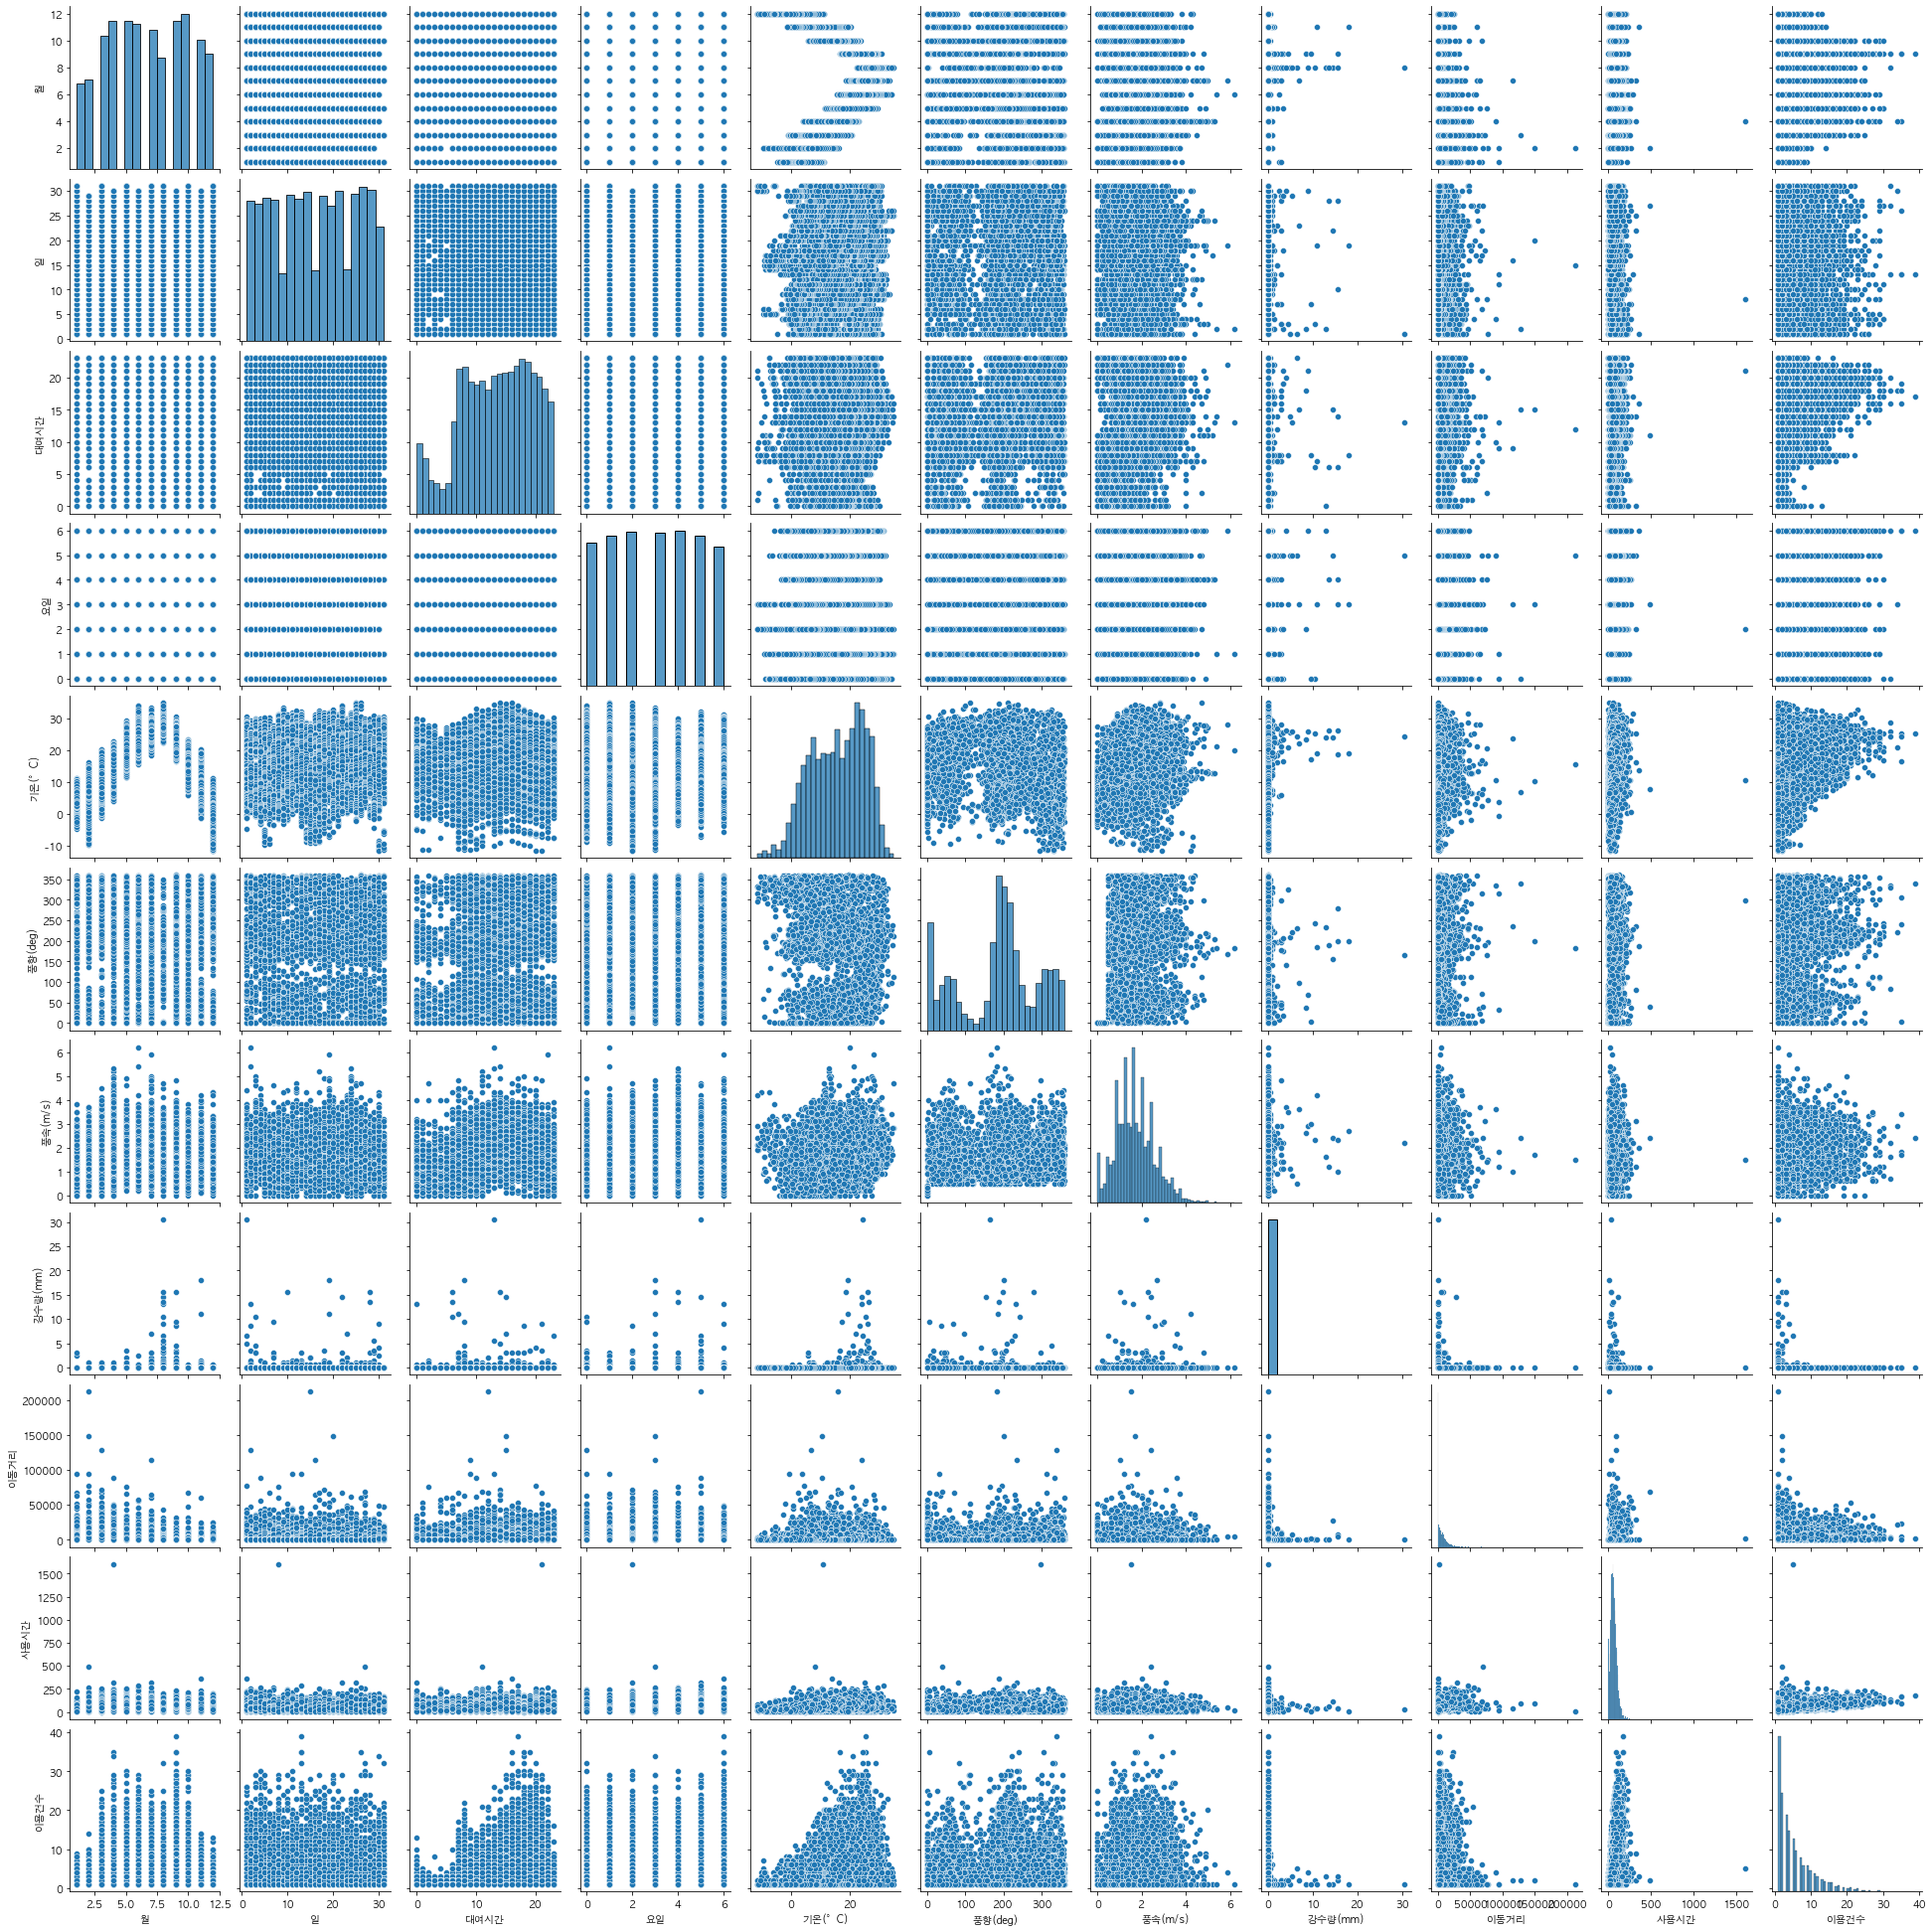

In [72]:
sns.pairplot(doksan)
plt.show()

# Modeling

## Encoding

In [73]:
doksan.columns.values

array(['월', '일', '대여시간', '요일', '기온(°C)', '풍향(deg)', '풍속(m/s)', '강수량(mm)',
       '이동거리', '사용시간', '이용건수'], dtype=object)

`요일`컬럼은 월요일부터 일요일 총 7일 (6벡터)를 가지기 때문에 **원핫 인코딩**으로 처리해줍니다.

In [74]:
doksan = doksan.join(pd.get_dummies(doksan['요일'], prefix="요일"))
doksan.head()

,월,일,대여시간,요일,기온(°C),풍향(deg),풍속(m/s),강수량(mm),이동거리,사용시간,이용건수,요일_0,요일_1,요일_2,요일_3,요일_4,요일_5,요일_6
0,1,1,0,2,-4.8,171.0,0.7,0.0,15620.000000,82.000000,1,0,0,1,0,0,0,0
1,1,1,13,2,-0.3,354.0,1.0,0.0,6240.000000,43.000000,1,0,0,1,0,0,0,0
2,1,1,15,2,1.3,150.3,1.0,0.0,9136.666667,73.333333,3,0,0,1,0,0,0,0
3,1,1,17,2,1.5,155.3,0.6,0.0,10560.000000,92.000000,2,0,0,1,0,0,0,0
4,1,1,18,2,1.0,176.5,1.5,0.0,2670.000000,15.000000,1,0,0,1,0,0,0,0


`label`을 인코딩 해줍니다.

In [75]:
dayofweek = ["요일_"+str(i) for i in range(7)]
features = ['월', '대여시간', '기온(°C)', '풍향(deg)', '풍속(m/s)', '강수량(mm)'] + dayofweek
features

['월',
 '대여시간',
 '기온(°C)',
 '풍향(deg)',
 '풍속(m/s)',
 '강수량(mm)',
 '요일_0',
 '요일_1',
 '요일_2',
 '요일_3',
 '요일_4',
 '요일_5',
 '요일_6']

## Train & Test Data Split

저희는 어떠한 특징(Features)로 인해 얼마나 공영자전거 따릉이를 사용하는가를 알아보기 위해서,

특징과 이용건수로 훈련데이터와 테스트 데이터를 분리시켜 예측을 해볼려고 합니다.

In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(doksan[features], doksan['이용건수'], test_size=0.2, random_state=42)

In [77]:
print(X_train.shape)
print(X_test.shape)

(4684, 13)
(1172, 13)


## 회귀 모델로 데이터셋 학습

In [78]:
# import (교차검증, 회귀 모델, XGB)
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model as lm
import xgboost as xgb
from scipy.stats import uniform, randint

# 모델 입력하기
models = [
    ('lr', lm.LinearRegression(n_jobs=-1)),
    ('ridge', lm.Ridge()),
    ('lasso', lm.Lasso()),
    ('elastic', lm.ElasticNet()),
    ('LassoLars', lm.LassoLars()),
    ('LogisticRegression', lm.LogisticRegression()),
    ('SGDRegressor', lm.SGDRegressor()),
    ('Perceptron', lm.Perceptron(n_jobs=-1))
   ,('xgboost', xgb.XGBRegressor())
]

n = 3
params = {
    'lr' : {
        'fit_intercept': [True, False],
        'normalize': [True, False],
    },
    'ridge': {
        'alpha': [0.01, 0.1, 1.0, 10, 100],
        'fit_intercept': [True, False],
        'normalize': [True, False],
    },
    'lasso': {
        'alpha': [0.1, 1.0, 10],
        'fit_intercept': [True, False],
        'normalize': [True, False],
    },
    'elastic': {
        'alpha': [0.1, 1.0, 10],
        'normalize': [True, False],
        'fit_intercept': [True, False],
    },
    'LassoLars': {
        'alpha': [0.1, 1.0, 10],
        'normalize': [True, False],
        'fit_intercept': [True, False],
    },
    'LogisticRegression': {
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 0.1, 1.0, 10, 100],
        'fit_intercept': [True, False],
    },
    'SGDRegressor': {
        'penalty': ['l1', 'l2'],
        'alpha': [0.001, 0.01, 0.1, 1.0, 10, 100],
        'fit_intercept': [True, False],
    },
    'Perceptron' :{
        'penalty': ['None', 'l1', 'l2'],
        'alpha': [0.001, 0.01, 0.1, 1.0, 10, 100],
        'fit_intercept': [True, False]
     }
       ,
    'xgboost': {
        "gamma": uniform(0, 0.5).rvs(n),
        "max_depth": range(2, 7), # default 3
        "n_estimators": randint(100, 150).rvs(n), # default 100
    }
}

best_model, best_mae = None, float('inf')
for model_name, model in models:
    param_grid = params[model_name]
    grid = GridSearchCV(model, cv=5, n_jobs=-1, param_grid=param_grid)
    grid = grid.fit(X_train, y_train)

    model = grid.best_estimator_
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)

    print(model_name, mae)

    if mae < best_mae:
        best_model = model

lr 3.4100546255979514
ridge 3.4064774729052854
lasso 3.402360806861669
elastic 3.4005428865044
LassoLars 3.402360770361259
LogisticRegression 4.351535836177474
SGDRegressor 10397643393434.389
Perceptron 4.397610921501706
xgboost 2.4700363167412


xgboost 모델이 MAE(실제값과 예측값의 차이)가 가장 낮았다.

`best_model`을 이용하여 xgboost 모델을 사용할 것이다.

In [79]:
best_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.05782402251709651,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=122, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## 피쳐 중요도

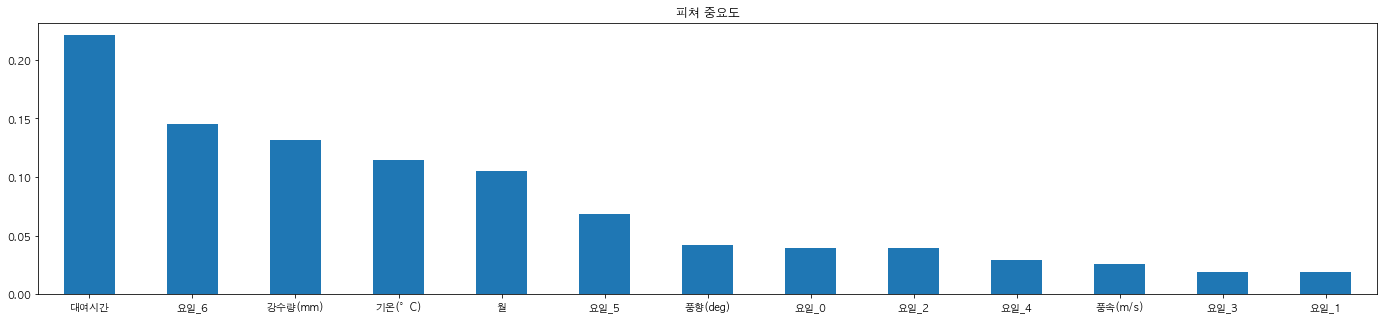

In [80]:
feature_importance = pd.Series(index=features, data=best_model.feature_importances_).sort_values(ascending=False)
feature_importance.plot(kind='bar', figsize=(24, 5), title="피쳐 중요도", rot=0)
plt.show()

위 그래프를 봤을 때, 이용건수가 `대여시간`이 가장 영향이 크고 그 뒤로 `요일_6`(일요일), `강수량`, `기온`, `요일_5`(토요일)이 줄을 이었다.

즉, **대여시간과 그 날의 날씨 그리고 주말인지 아닌지**가 금천구민의 자전거 이용 횟수에 영향을 미치는 것으로 보인다.

## 예측값 분포

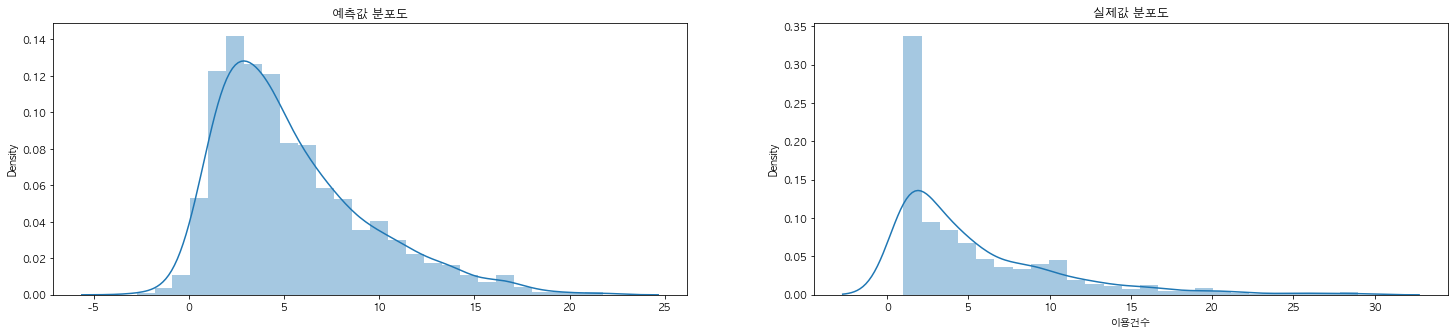

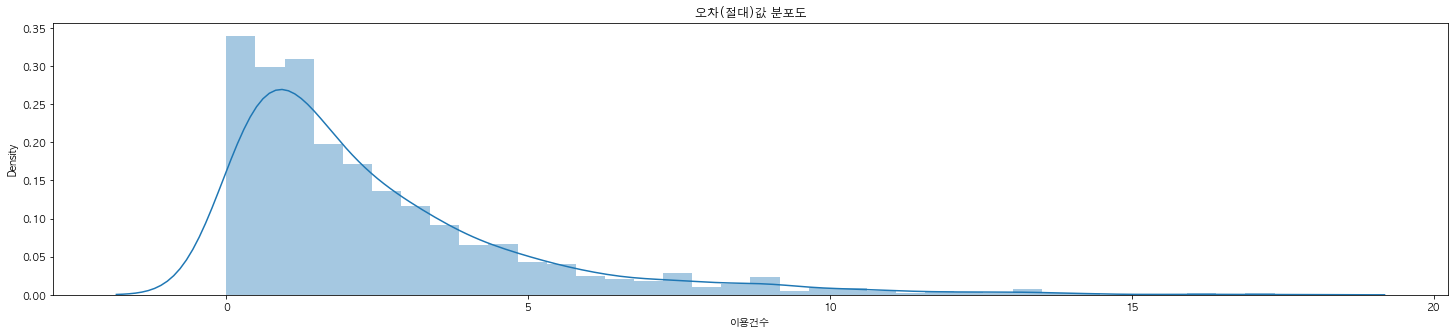

In [81]:
predictions = best_model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(25, 5))
sns.distplot(predictions, ax=axes[0])
axes[0].set_title("예측값 분포도")
sns.distplot(y_test, ax=axes[1])
axes[1].set_title("실제값 분포도")
plt.show()

plt.figure(figsize=(25, 5))
sns.distplot(abs(predictions - y_test))
plt.title("오차(절대)값 분포도")
plt.show()

테스트 데이터에 약간의 아웃라이어가 존재한다는 것을 확인할 수 있다.

## 금천구 모델 학습 및 예측

In [82]:
cols = ['월', '일', '대여시간', '요일','기온(°C)', '풍향(deg)', '풍속(m/s)', '강수량(mm)']

results = {}
total = df['대여소명'].nunique()

for idx, (name, _df) in enumerate(df.groupby('대여소명'), 1):
    print("[%d/%d] %s" %(idx, total, name), end=' ')

    try:
        _df = _df.groupby(cols)['이용건수'].sum().reset_index()
        _df = _df.join(pd.get_dummies(_df['요일'], prefix="요일"))

        print(_df.shape)

        X_train, X_test, y_train, y_test = train_test_split(_df[features], _df['이용건수'], test_size=0.2, random_state=42)

        param_grid = {
            "gamma": uniform(0, 0.5).rvs(n),
            "max_depth": range(2, 7), # default 3
            "n_estimators": randint(100, 150).rvs(n), # default 100
        }

        grid = GridSearchCV(xgb.XGBRegressor(), cv=5, n_jobs=-1, param_grid=param_grid)
        grid = grid.fit(X_train, y_train)

        model = grid.best_estimator_
        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)

        results[name] = {}
        results[name]['model'] = model
        results[name]['mae'] = mae
        results[name]['errors'] = predictions - y_test

    except:
        continue

[1/55] 1804. 독산역 2번출구 자전거주차장 (4758, 16)
[2/55] 1805. 서울디지털운동장 앞 (3426, 16)
[3/55] 1806. 에이스하이엔드타워9차 앞 (3043, 16)
[4/55] 1808. 에이스하이엔드타워8차 앞 (2489, 16)
[5/55] 1809. LG전자 별관동(호서대 벤처타워 맞은편) (1742, 16)
[6/55] 1812. 갑을그레이트밸리 앞 (3528, 16)
[7/55] 1814. 두산위브아파트 옆 상가건물 앞 (4058, 16)
[8/55] 1816. 금천폭포공원 앞 (2000, 16)
[9/55] 1819. 금천구청 앞 자전거거치대 (3688, 16)
[10/55] 1820. 신한은행 시흥대로금융센터지점 (2325, 16)
[11/55] 1821. 홈플러스 시흥점 맞은편 다비치안경 앞 (4130, 16)
[12/55] 1822. 서울 시흥동우체국 앞 (4627, 16)
[13/55] 1823. 상신정비공업 앞 (2814, 16)
[14/55] 1824. 독산근린공원 입구 (5661, 16)
[15/55] 1825. 한신아파트 앞 육교 아래 (3321, 16)
[16/55] 1826. 한신코아 앞 (3373, 16)
[17/55] 1827. 독산보도육교 앞 자전거 보관소 (5856, 16)
[18/55] 1828. 한양수자인아파트 앞 (3801, 16)
[19/55] 1829. 홈플러스 금천점 앞 (4805, 16)
[20/55] 1830. 빅마켓 금천점 앞 (4518, 16)
[21/55] 1831. 메이퀸웨딩컨벤션 앞 (3024, 16)
[22/55] 1833. 독산역 1번출구 앞 자전거보관소 (4841, 16)
[23/55] 1834. 월드메르디앙 벤처센터 2차 (4764, 16)
[24/55] 1835. STX V타워 (3469, 16)
[25/55] 1836. 금천구립 독산도서관 (633, 16)
[26/55] 1839. 수출의 다리 아래 (2957, 16)
[27/55] 1840. 솔브레인이엔

In [83]:
errors = np.array([result['mae'] for result in results.values()])
errors.mean()

0.9618291440867707

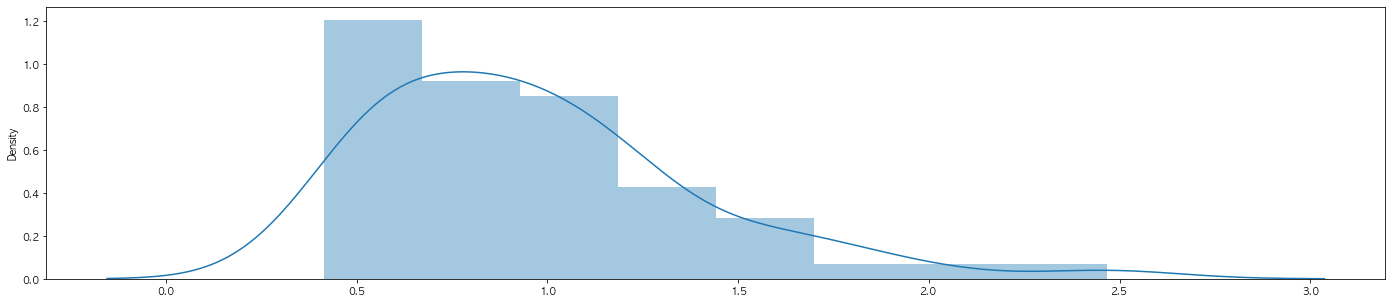

In [84]:
plt.figure(figsize=(24, 5))
sns.distplot(errors)
plt.show()